Задание
1. Возьмите из прошлого домашнего задания ряд — стационарный и не стационарный.
2. Приблизьте оба варианта моделями из класса MA.
3. Оцените качество и пришлите соображения, почему была выбрана та или иная модель.

Сначала импортируем все библиотеки:

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt

from scipy.stats import boxcox
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

In [70]:
series_airline_all = pd.read_csv("Series/international-airline-passengers.csv")
series_mean_monthly_all = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")

In [71]:
series_airline = pd.read_csv("Series/international-airline-passengers.csv").Count
series_mean_monthly = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv").Deg

In [72]:
series_airline_all['Month'] = pd.to_datetime(series_airline_all['Month'], format="%Y-%m")
series_mean_monthly_all['Month'] = pd.to_datetime(series_mean_monthly_all['Month'], format="%Y-%m")

series_airline_all.set_index('Month', inplace=True)
series_mean_monthly_all.set_index('Month', inplace=True)

In [73]:
print('series_airline_all ', series_airline_all.index.is_monotonic_increasing)
print('series_mean_monthly_all ', series_mean_monthly_all.index.is_monotonic_increasing)

series_airline_all  True
series_mean_monthly_all  True


In [74]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

### Сначала исследуем временной ряд - количество пассажиров авиалайнера. 
Проверим временной ряд на стационарность:

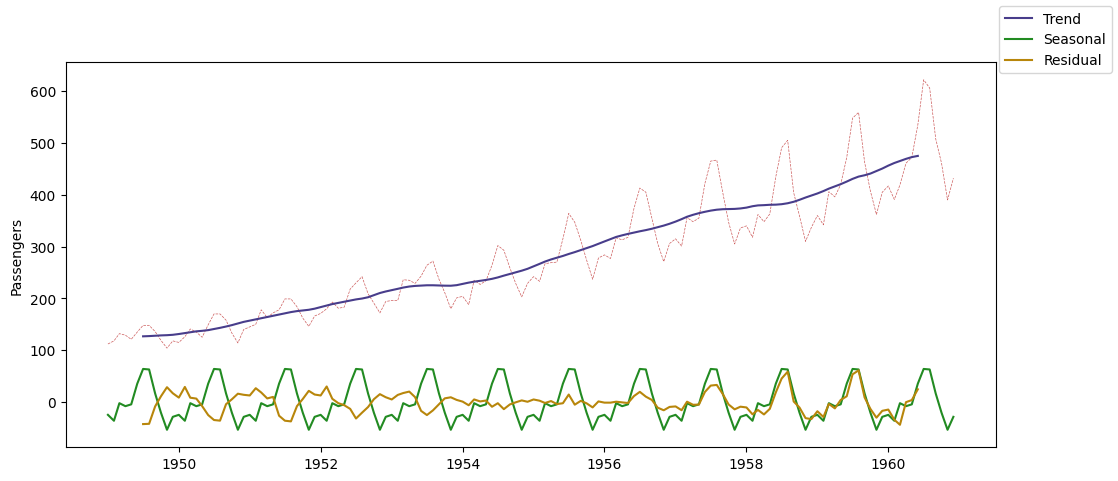

In [75]:
decomposed = seasonal_decompose(series_airline_all['Count']) 

fig, ax = plt.subplots(1, 1, figsize=[12, 5])

ax.plot(series_airline_all['Count'], c='indianred', linewidth=0.5, linestyle='--')
ax.plot(decomposed.trend, c='darkslateblue', label='Trend')
ax.plot(decomposed.seasonal, c='forestgreen', label='Seasonal')
ax.plot(decomposed.resid, c='darkgoldenrod', label='Residual')
ax.set_ylabel('Passengers')

fig.legend();

Мы видим, что присутствует возрастающий тренд и ежегодная сезонность

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


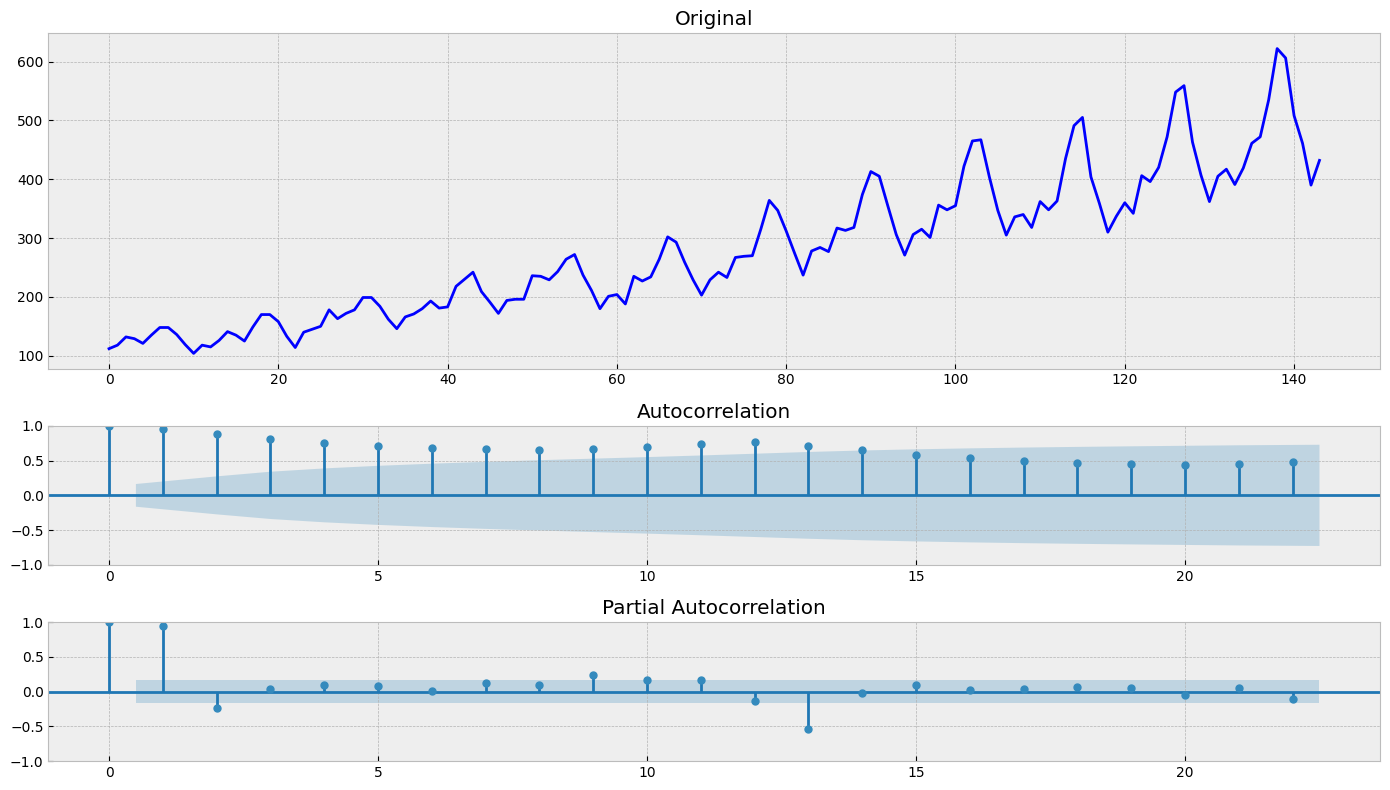

In [76]:
tsplot(series_airline)

Ряд не стационарен.

**Скользящее среднее**

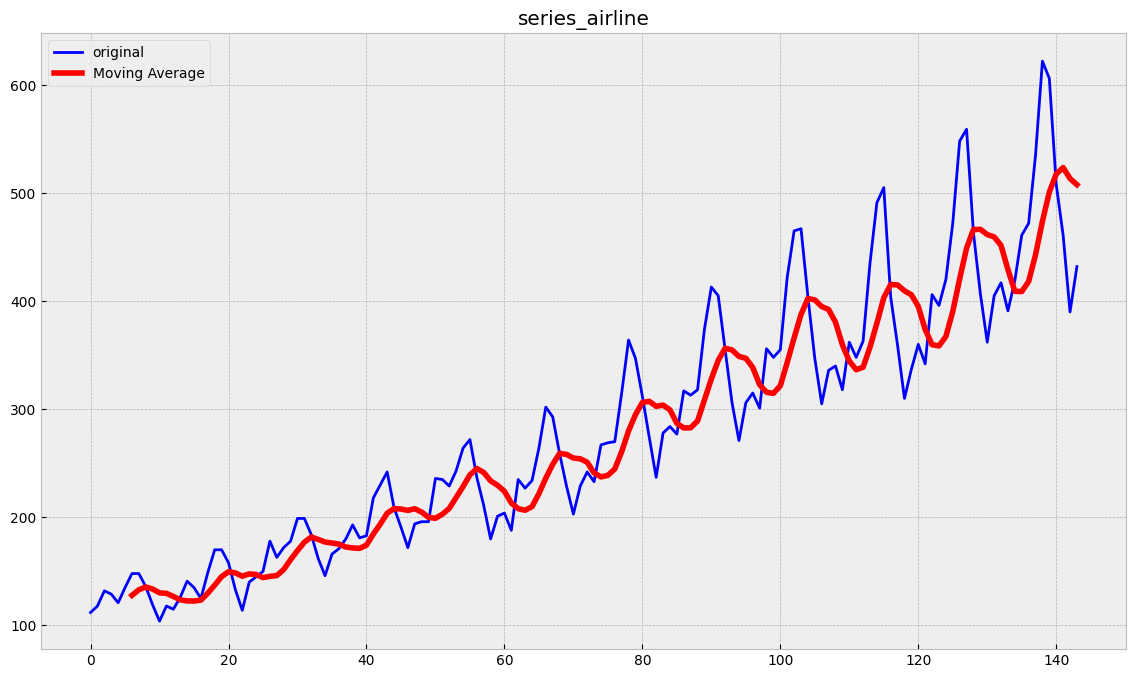

In [77]:
ma=series_airline.rolling(7).mean()

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('series_airline')
    plt.plot(series_airline, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='4', label='Moving Average')
    plt.legend()

**Взвешенное скользящее среднее**

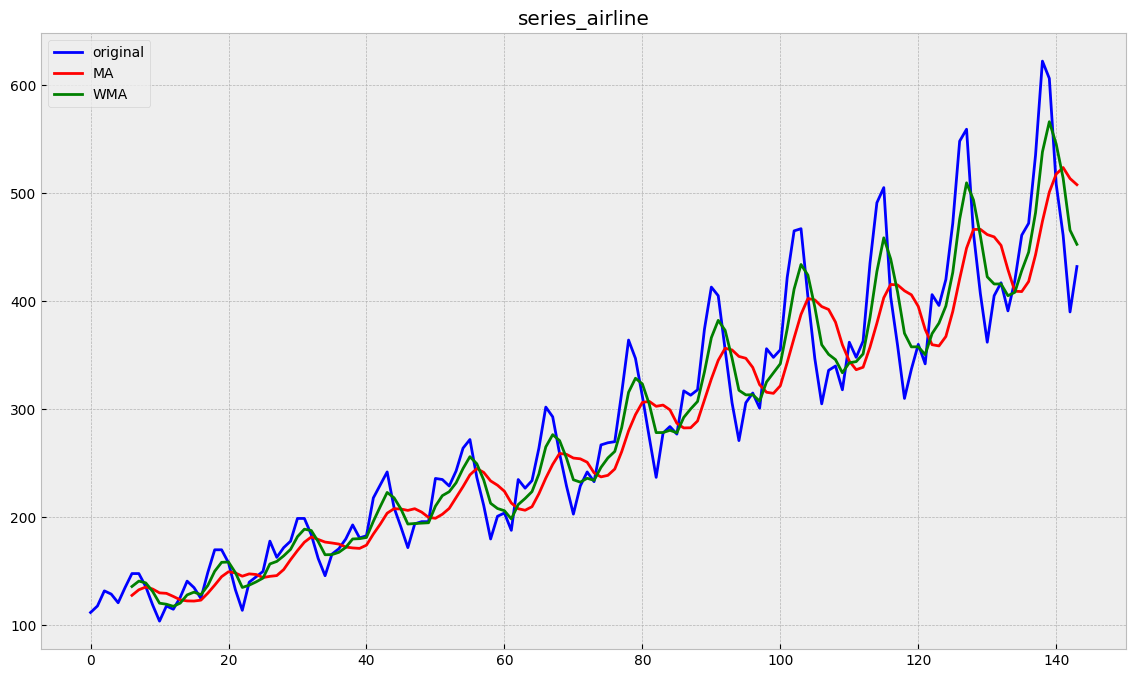

In [78]:
weights=np.array([1,1,2,3,5,8,13])
wma = series_airline.rolling(7).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('series_airline')
    plt.plot(series_airline, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

**Экспоненциальное сглаживание**

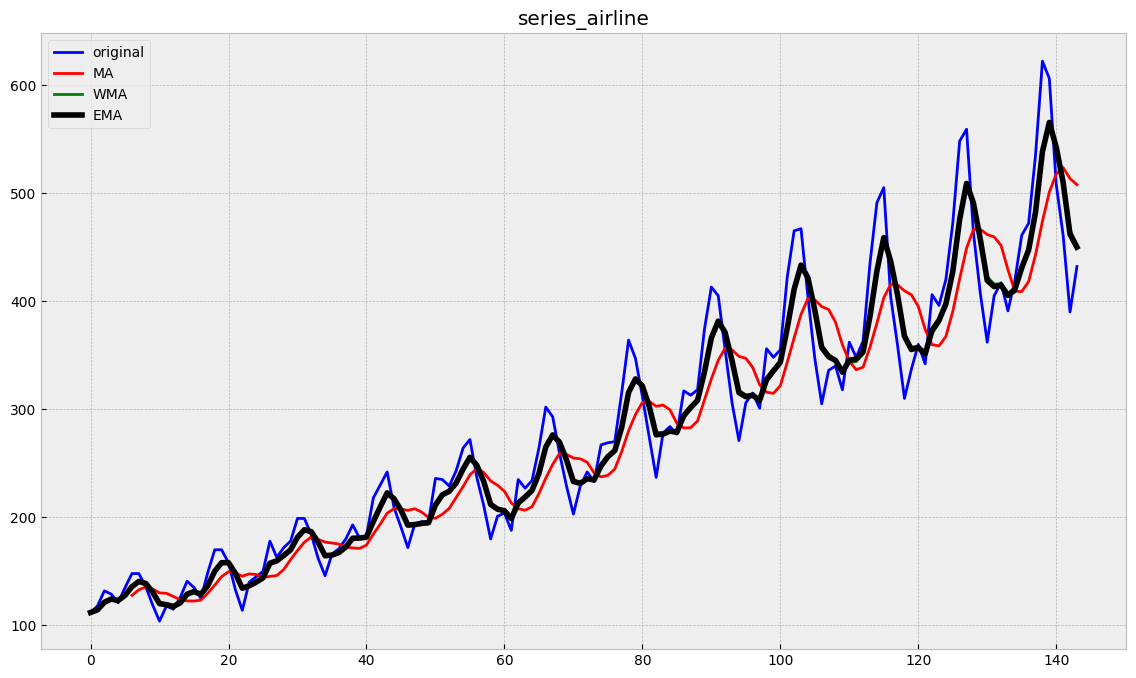

In [79]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

ema = exponential_moving_average(series_airline, 0.4)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('series_airline')    
    plt.plot(series_airline, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

Из графика видно, что экспоненциальное сглаживание с коэффициентом alpha 0.4 повторяет взвешенное скользящее среднее

**Двойное экспоненциальное сглаживание**

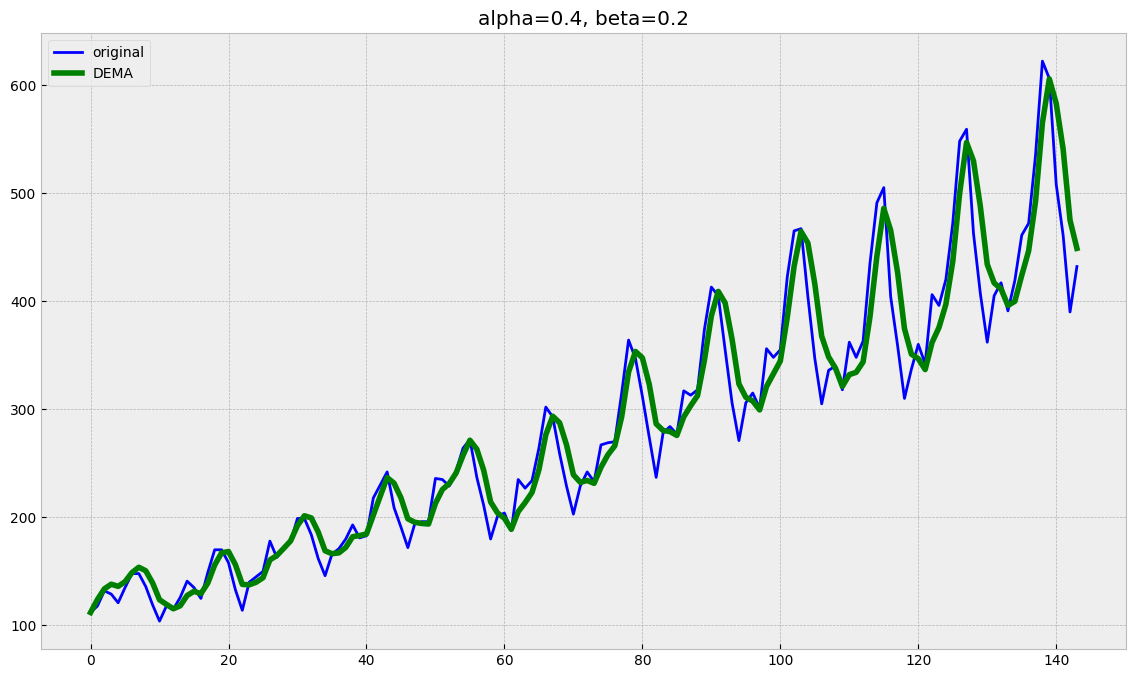

In [80]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

alpha=0.4
beta=0.2
dema = double_ema(series_airline, alpha, beta)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('series_airline')    
    plt.plot(series_airline, color='blue',label='original')
    plt.plot(dema, color='green', linewidth='4', label='DEMA')
    plt.title("alpha={}, beta={}".format(alpha, beta))
    plt.legend()

Из графика видно, что двойное экспоненциальное сглаживание с коэффициентами alpha 0.4 и beta 0.2 вполне неплохо описывает наш ряд

**Хольт-Винтерс (учтем сезонность)**

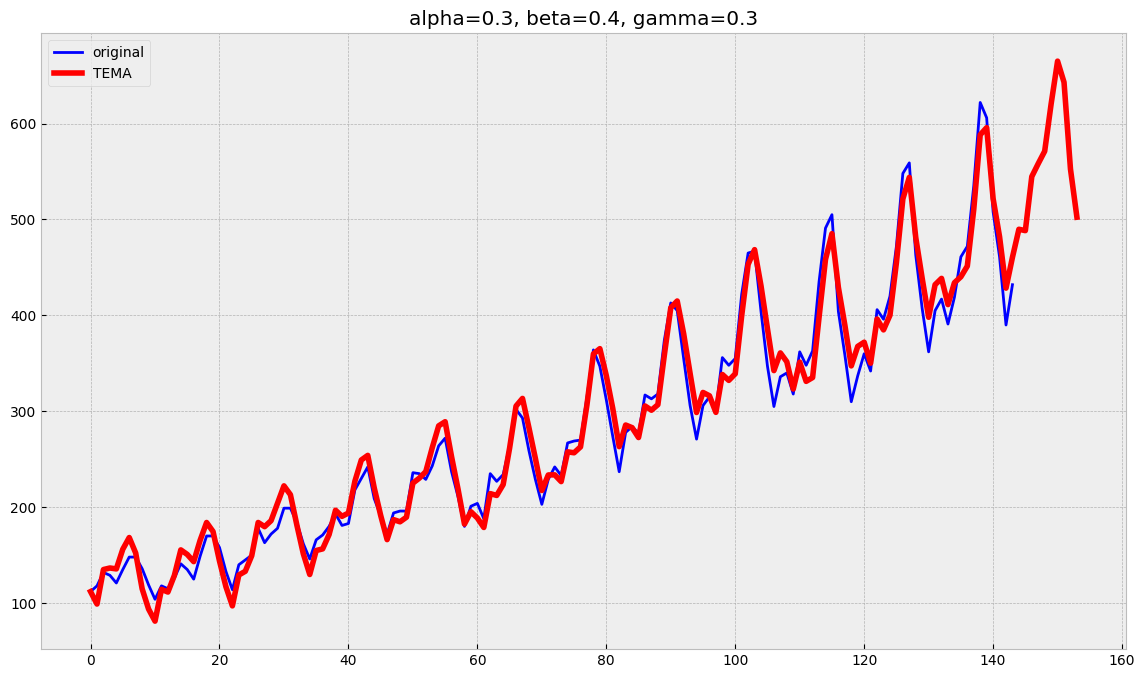

In [81]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = sum([float(series[i + slen] - series[i]) / slen]) / slen
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

alpha=0.3
beta=0.4
gamma=0.3
n_periods2_pred=10

tema = triple_exponential_smoothing(series_airline, 12, alpha, beta, gamma, n_periods2_pred)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('series_airline')      
    plt.plot(series_airline, color='blue',label='original')
    plt.plot(tema, color='red', linewidth='4', label='TEMA')
    plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
    plt.legend()

Из графика видно, что с коэффициентами alpha 0.3, beta 0.4 и gamma 0.3 мы отлично описываем наш ряд и полученный прогноз на 10 значений вперед очень похож на историческое поведение ряда

**Теперь перейдем к модели: подберем параметры и протестируем результат на валидационной и тестовой выборках**

In [82]:
train_size=round(len(series_airline)*.7)
test_size=round(len(series_airline)*.25)

In [83]:
train, test, val = series_airline[:train_size], series_airline[train_size:train_size+test_size], \
    series_airline[train_size+test_size:]

def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1365.3324154366674
        x: [ 1.000e+00  1.822e-02  1.000e+00]
      nit: 6
      jac: [-3.926e+02  9.095e-05 -0.000e+00]
     nfev: 60
     njev: 15
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


**Проверим результат модели на тестовых данных**

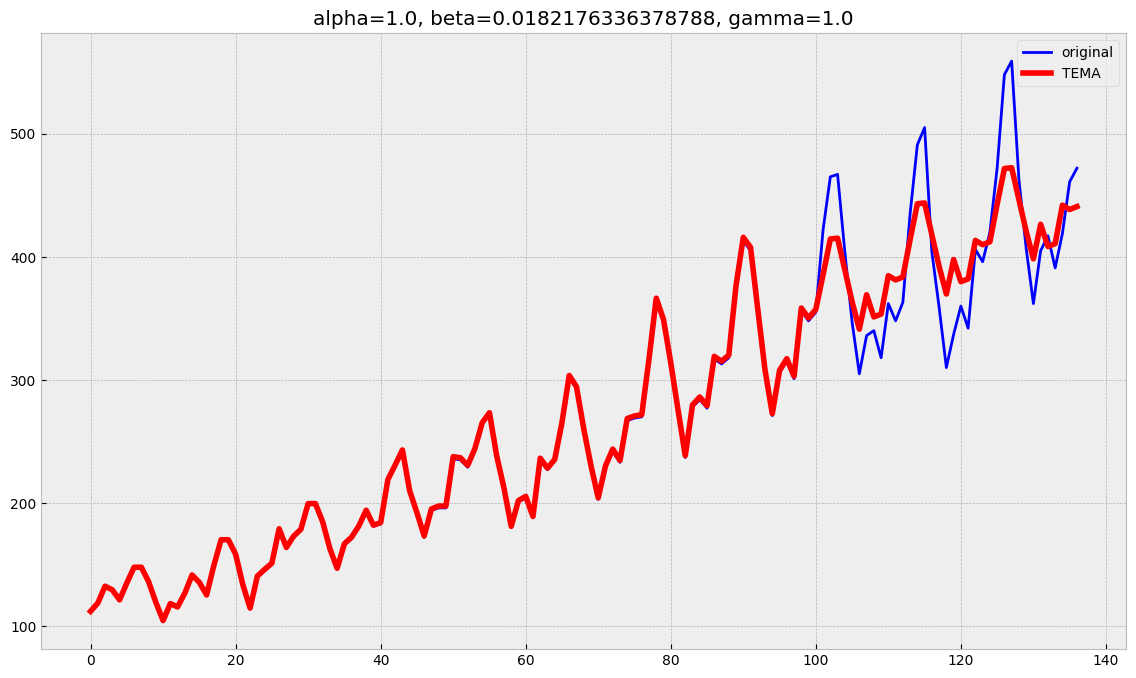

In [85]:
tema = triple_exponential_smoothing(train, 12, alpha_opt, beta_opt, gamma_opt, len(test))
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('airlines_passengers')      
    plt.plot(series_airline[:train_size+test_size], color='blue',label='original')
    plt.plot(tema, color='red', linewidth='4', label='TEMA')
    plt.title("alpha={}, beta={}, gamma={}".format(alpha_opt, beta_opt, gamma_opt))
    plt.legend()

**Проверим результат модели на валидационных данных**

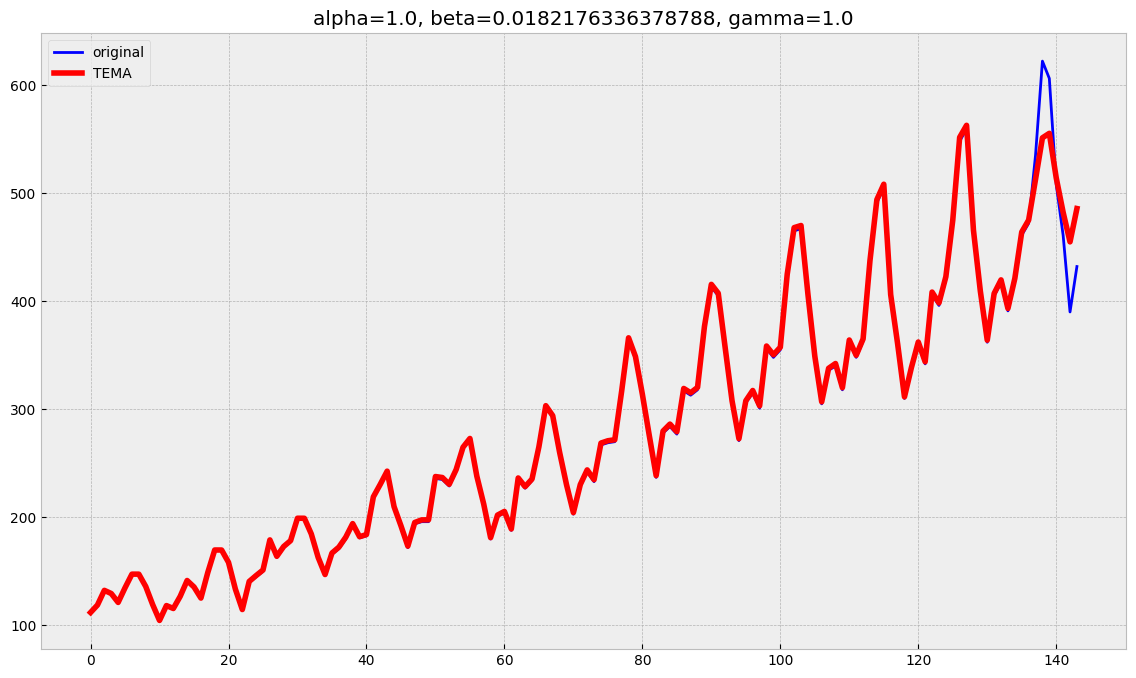

In [87]:
tema = triple_exponential_smoothing(series_airline[:train_size+test_size], 12, alpha_opt, beta_opt, gamma_opt, len(val))
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('series_airline')      
    plt.plot(series_airline, color='blue',label='original')
    plt.plot(tema, color='red', linewidth='4', label='TEMA')
    plt.title("alpha={}, beta={}, gamma={}".format(alpha_opt, beta_opt, gamma_opt))
    plt.legend()

Амплитуда колебаний ряда увеличивается, а наша модель немного их сглаживает. Теперь перейдем к оценке качества модели

**Разобьем ряд только на тренировочную и тестовую выборки, также подберем коэффиенты и проверим качество модели**

In [89]:
train, val = series_airline[:train_size], series_airline[train_size:]

def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(series_mean_monthly):
        result = triple_exponential_smoothing(train_split, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)

    return np.mean(np.array(errors))

opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 9.539210950455393e-09
        x: [ 5.555e-02  1.906e-01  9.115e-01]
      nit: 68
      jac: [-1.758e-06 -7.367e-06  4.125e-06]
     nfev: 340
     njev: 85
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


Проверим результат модели на валидационных данных

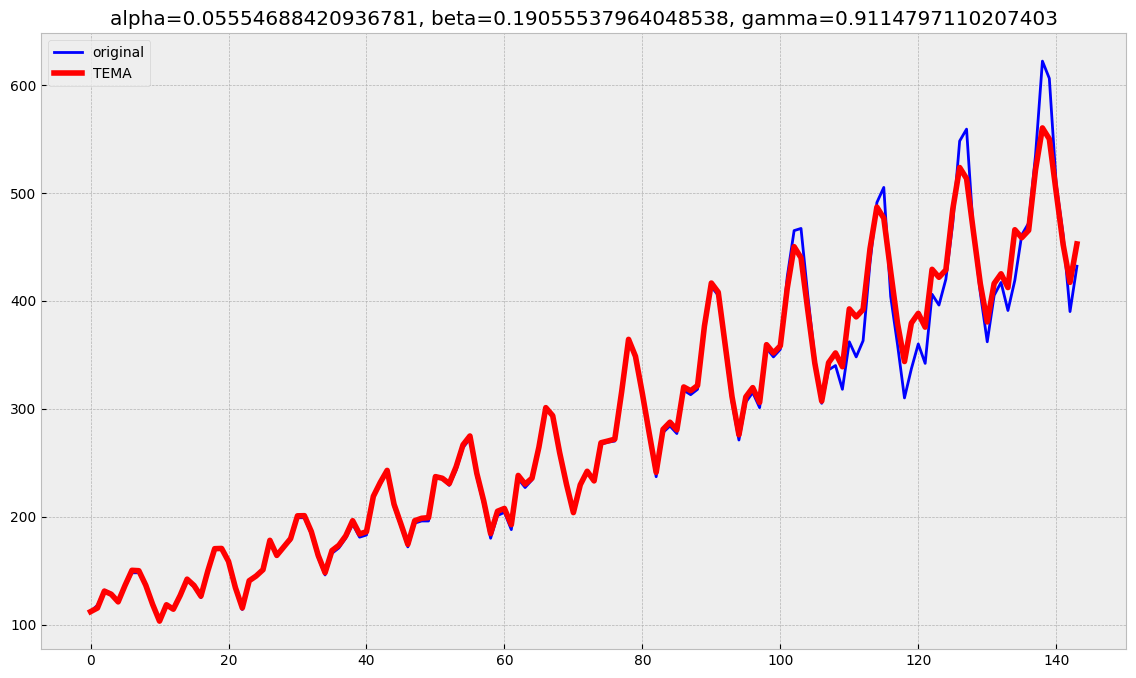

In [90]:
tema = triple_exponential_smoothing(series_airline[:train_size], 12, alpha_opt, beta_opt, gamma_opt, len(val))
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('airlines_passengers')      
    plt.plot(series_airline, color='blue',label='original')
    plt.plot(tema, color='red', linewidth='4', label='TEMA')
    plt.title("alpha={}, beta={}, gamma={}".format(alpha_opt, beta_opt, gamma_opt))
    plt.legend()

Измерим качетсво модели метрикой r2_score

In [91]:
r2_score(y_pred=tema, y_true=series_airline)

0.9862469228729048

**ВЫВОД**: мы используем модель Хольта-Винтерса, так как в наличии тренд, сезоность и результат модели описывает практически 100% дисперсии исследуемого временного ряда

### Теперь исследуем временной ряд - среднемесячная температура
Проверим временной ряд на стационарность:

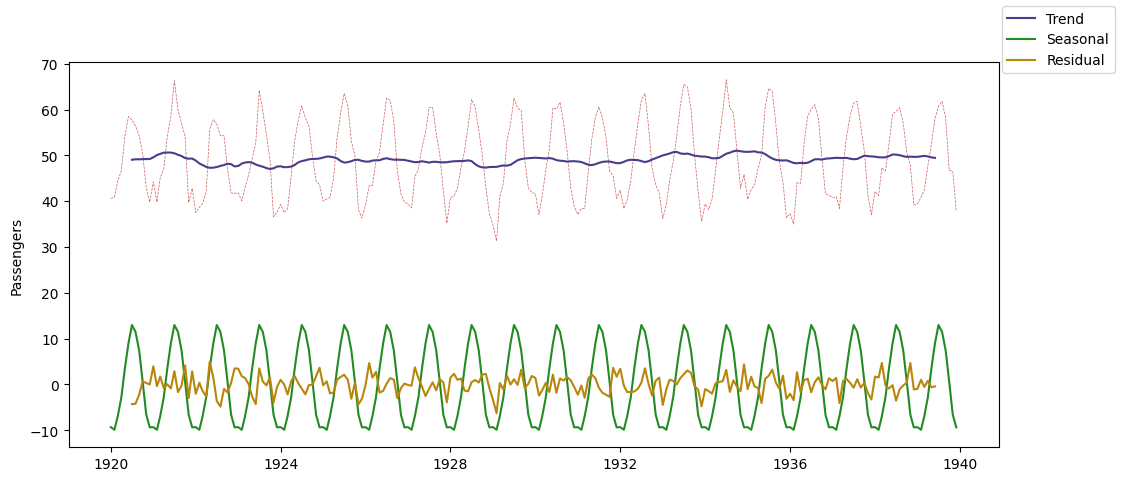

In [93]:
decomposed = seasonal_decompose(series_mean_monthly_all['Deg']) 

fig, ax = plt.subplots(1, 1, figsize=[12, 5])

ax.plot(series_mean_monthly_all['Deg'], c='indianred', linewidth=0.5, linestyle='--')
ax.plot(decomposed.trend, c='darkslateblue', label='Trend')
ax.plot(decomposed.seasonal, c='forestgreen', label='Seasonal')
ax.plot(decomposed.resid, c='darkgoldenrod', label='Residual')
ax.set_ylabel('Passengers')

fig.legend();

Из графика мы точно видим сезонность, но особого тренда не наблюдаем.

Results of Dickey-Fuller Test:
Test Statistic                  -3.255492
p-value                          0.016989
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


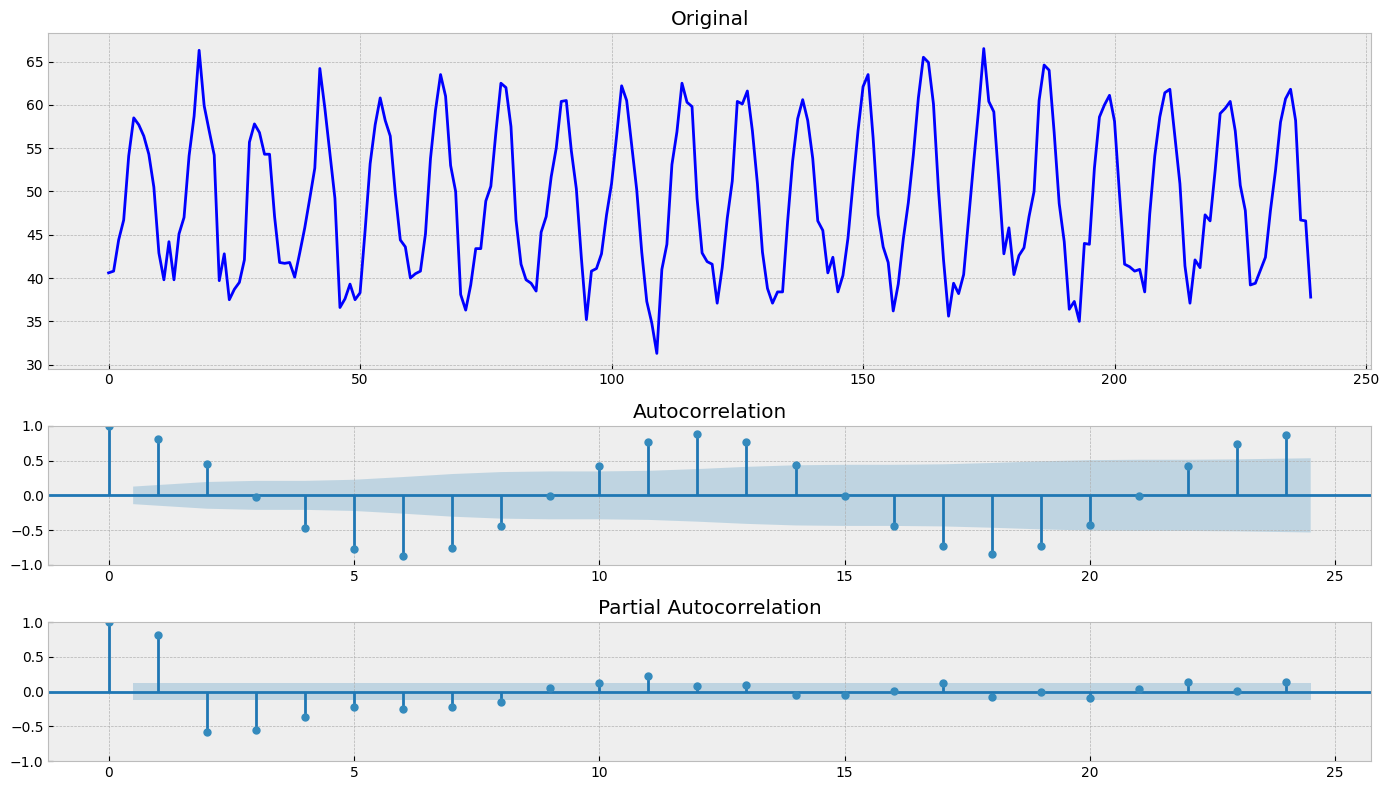

In [94]:
tsplot(series_mean_monthly)

Мы можем говорить, что ряд стационарен - p-value менее 0.05  и значение тестовой статистики на уровне первого критического значения, коррелограмма плавно убывает.

**Скользящее среднее**

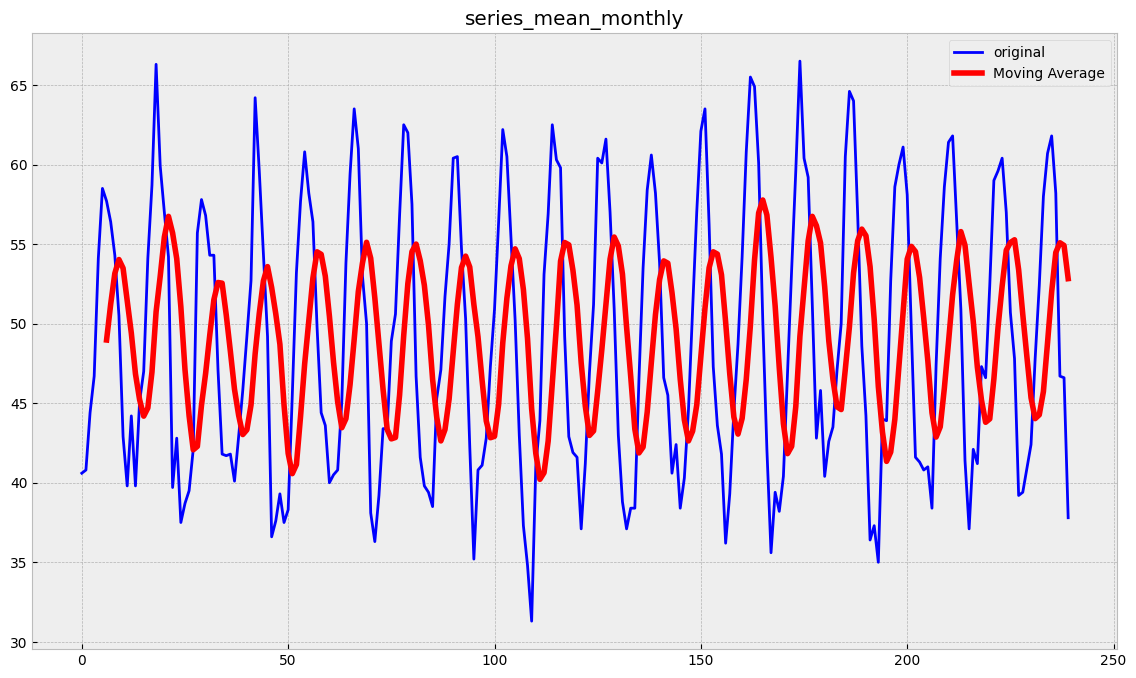

In [97]:
ma=series_mean_monthly.rolling(7).mean()

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('series_mean_monthly')
    plt.plot(series_mean_monthly, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='4', label='Moving Average')
    plt.legend()

Скользящее среднее повторяет поведение ряда, хотя и явно не учитывают его особенностей

**Взвешенное скользящее среднее**

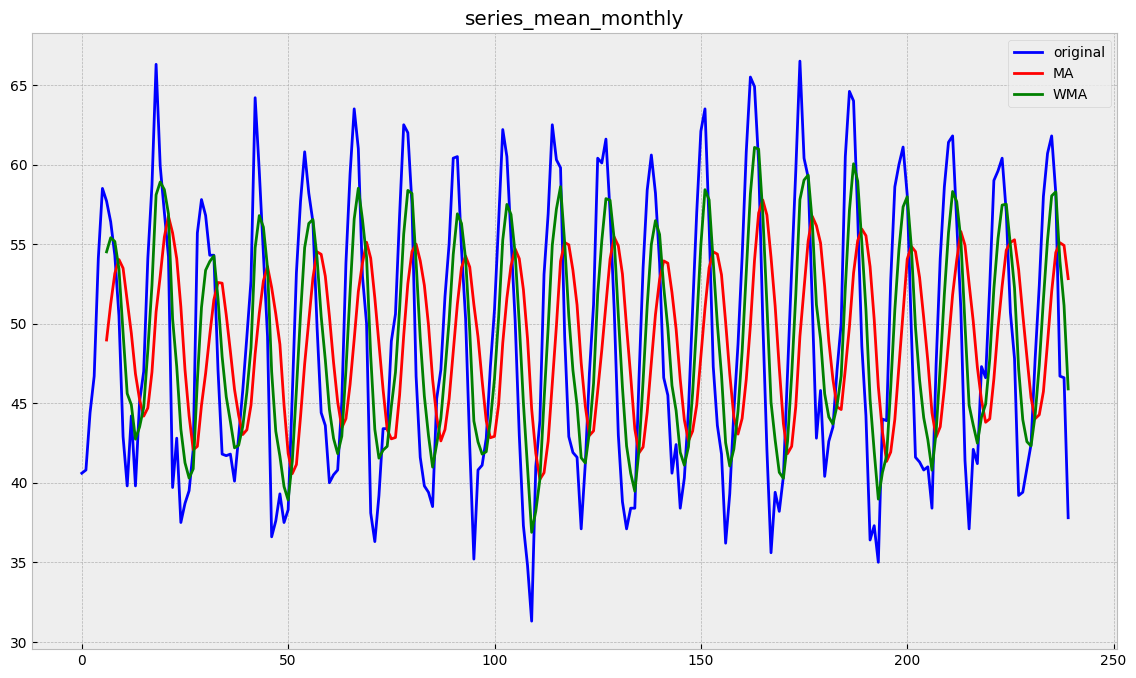

In [98]:
weights=np.array([1,1,2,3,5,8,13])
wma = series_mean_monthly.rolling(7).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('series_mean_monthly')
    plt.plot(series_mean_monthly, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

**Экспоненциальное сглаживание**

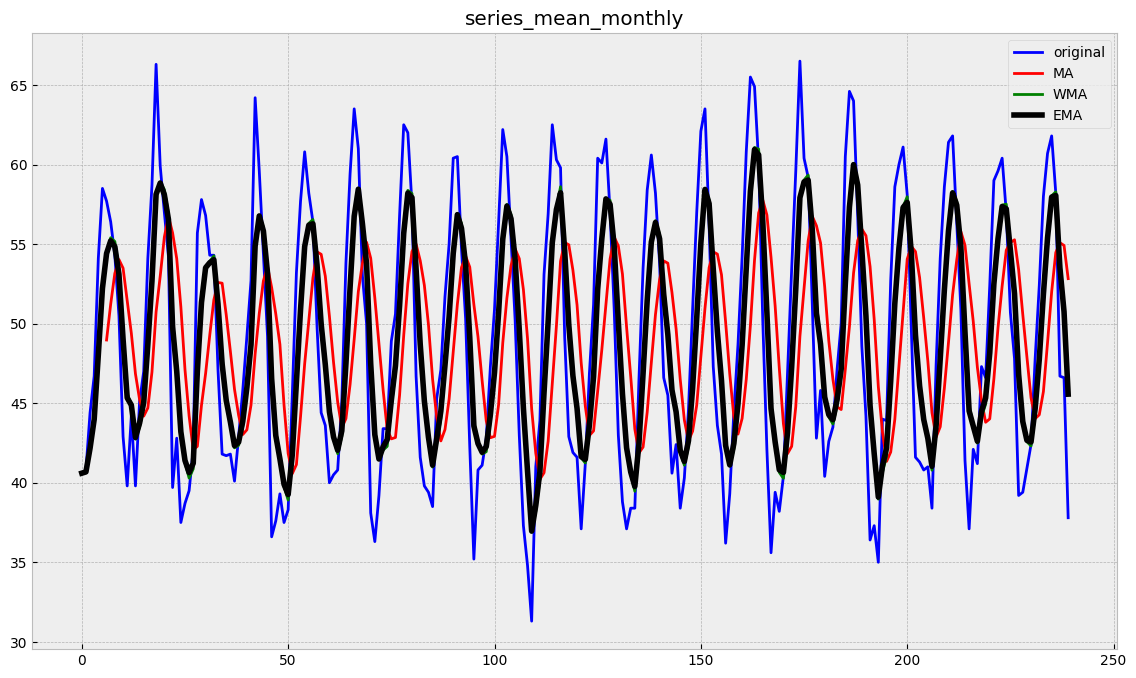

In [99]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

ema = exponential_moving_average(series_mean_monthly, 0.4)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('series_mean_monthly')    
    plt.plot(series_mean_monthly, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

Из графика видно, что с коэффициентом alpha 0.4 (как и в примере с количеством пассажиров) экспоненциальное сглаживание повторяет взвешенное скользящее среднее

**Двойное экспоненциальное сглаживание**

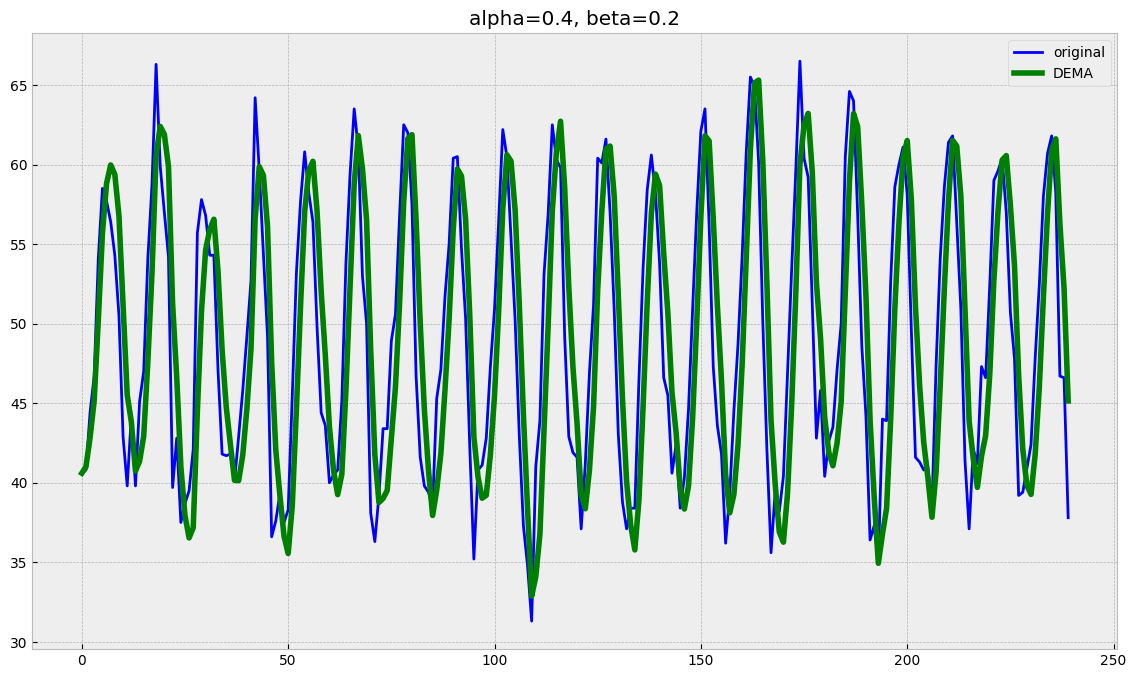

In [100]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

alpha=0.4
beta=0.2
dema = double_ema(series_mean_monthly, alpha, beta)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('series_mean_monthly')    
    plt.plot(series_mean_monthly, color='blue',label='original')
    plt.plot(dema, color='green', linewidth='4', label='DEMA')
    plt.title("alpha={}, beta={}".format(alpha, beta))
    plt.legend()

С теми же коэффициентами (alpha 0.4 и beta 0.2) мы вполне неплохо описываем наш ряд

**Хольт-Винтерс (учтем сезонность)**

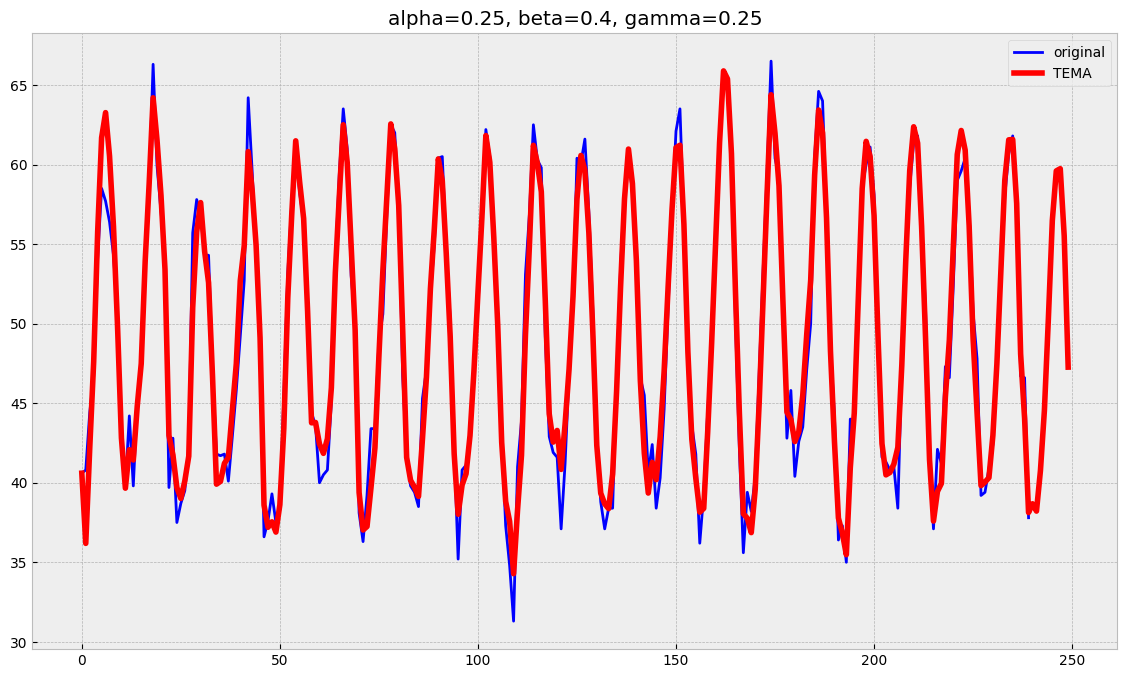

In [130]:
alpha=0.25
beta=0.4
gamma=0.25
n_periods2_pred=10

tema = triple_exponential_smoothing(series_mean_monthly[:], 12, alpha, beta, gamma, n_periods2_pred)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('series_mean_monthly')      
    plt.plot(series_mean_monthly, color='blue',label='original')
    plt.plot(tema, color='red', linewidth='4', label='TEMA')
    plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
    plt.legend()

Из графика видно, что с коэффициентами alpha 0.25 и beta 0.4 и gamma 0.25 мы отлично описываем наш ряд и полученный прогноз на 10 значений вперед очень похож на историческое поведение ряда

Теперь с вычисленными коэффициентами можем оценить качество модели

In [143]:
train, val = series_mean_monthly[:train_size], series_mean_monthly[train_size:]

def mse_cross_val(X,):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    k=0
    for train_split, test_split in split.split(series_mean_monthly):
        result = triple_exponential_smoothing(train_split, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)
        k+=1
#     print(k,np.mean(np.array(errors)))
        
    return np.mean(np.array(errors))

opt = minimize(mse_cross_val, x0=[0.25, 0.4, 0.25], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 8.443313227419032e-08
        x: [ 7.348e-02  2.709e-01  8.640e-01]
      nit: 30
      jac: [ 5.168e-06  5.218e-06 -3.665e-06]
     nfev: 152
     njev: 38
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


Проверим результат модели на валидационных данных

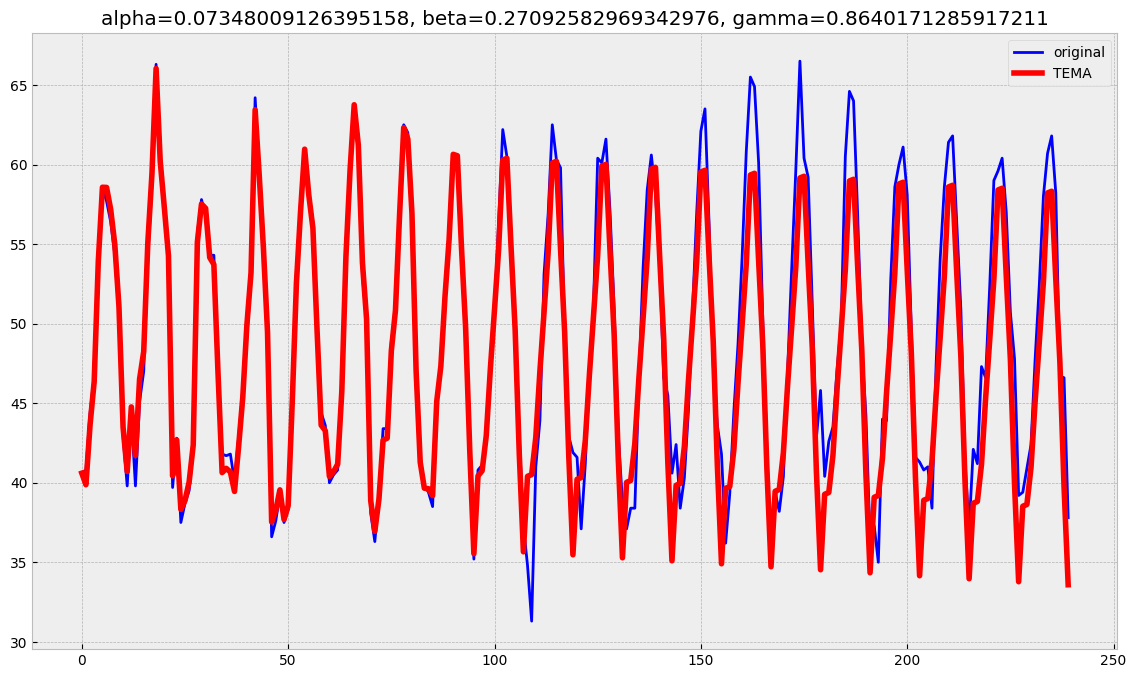

In [144]:
tema = triple_exponential_smoothing(series_mean_monthly[:train_size], 12, alpha_opt, beta_opt, gamma_opt, len(val))
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('series_mean_monthly')      
    plt.plot(series_mean_monthly, color='blue',label='original')
    plt.plot(tema, color='red', linewidth='4', label='TEMA')
    plt.title("alpha={}, beta={}, gamma={}".format(alpha_opt, beta_opt, gamma_opt))
    plt.legend()

In [145]:
r2_score(y_pred=tema, y_true=series_mean_monthly)

0.8936106107472275

**ВЫВОД**: Мы тем же методомполучили неплохое качество модели